# Introduction

## Using Remotely Piloted Aircraft Systems (RPAS) for environmental monitoring

Week 8 is focused on using drones for science and demonstrating what is required to go from images to data you can use to answer agricultural questions.

## Setup

### Run the labs

You can run the labs locally on your machine or you can use cloud environments provided by Google Colab. **If you're working with Google Colab be aware that your sessions are temporary and, if required, you'll need to take care to save, backup, and download your work.**

<a href="https://colab.research.google.com/github/data-analysis-3300-3003/colab/blob/main/lab-8.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Background 

A background to drone remote sensing will be provided as a short lecture, along with a show and tell of the platforms and cameras used by researchers within the Centre for Water and Spatial Science (CWSS) before using this notebook to demonstrate analysis techniques for working with drone data.

The lecture will provide a high-level overview of:

1. **Remote sensing- When are drones the right tool for the job?**
    * Spatial Resolution (pixel size). 
    * Scale (the area you need to cover and flight time etc.).
<p></p>

2. **Drone safety and regulations** 
    * See Civil Aviation Safety Authority (CASA) - <a href="https://www.casa.gov.au/knowyourdrone/drone-rules" target="_blank">Drone rules</a>.
<p></p>

3. **Overview of Types of Drones and Sensor**
    * Interactive show and tell of platforms and cameras used by researchers within the Centre for Water and Spatial Science.
<p></p>

4. **Mission Planning 101**
    * The key to good mission planning and data quality is to think through the question you are trying to answer. You should try and resolve these key questions at the mission planning stage:
        * What is the required ground pixel size, and what image overlap/flight path is needed? 
        * How accurately do you need to know the ground location? Do you require survey control?
        * Is a snapshot of relative pixel difference within one flight sufficient, or will you be comparing changes in data across time from multiple flights? Do you need to consider calibration?
        * Are there any hazards or safety considerations in the area of interest? What is the weather looking like for my planned flying day? What time of day should I be flying to get the best data quality?
    * Once you've thought through this, the next step is using mission planning software to develop a flight plan. Here are some examples of mission planning software:
        * <a href="https://www.dji.com/au/ground-station-pro" target="_blank">DJI GS Pro</a>
        * <a href="https://www.pix4d.com/product/pix4dcapture/" target="_blank">Pix4D Capture</a>
        * <a href="https://www.dronedeploy.com/product/mobile/" target="_blank">Drone Deploy</a>
<p></p>

5. **Thinking about calibration**
    * ***Geometric Calibration***
        * ***Inertial Measurement Unit (IMU)***: IMU measures force, angular velocity, and attitude (accelerometer, barometer, gyroscope, and thermometer). The IMU keeps the drone flying straight on the path outlined in your mission planning.  
        * ***Ground Control Points (GCP)***: GCPs are known locations in the imagery that are surveyed accurately and used to georeference the imagery. Identifiable objects are spaced across the flight area and surveyed with an RTK GPS. Some GCPs are commonly left out of image processing and used as checkpoints to verify the accuracy of the final orthophoto. 
        * ***Real-Time Kinematic (RTK) Drones***: RTK drone survey use real-time correction with location data from a GPS while the drone is capturing imagery. As these platforms reduce in price and depending on the accuracy required from the final product, it may remove the need for a lot of GCPs. 

    * ***Radiometric Calibration***
        * Multispectral imaging sensors do not directly measure reflectance. Instead, they measure at-sensor radiance, the radiant flux received by the sensor. Each image is a matrix of digital numbers relative to flight conditions. Radiometric calibration is required to convert raw digital numbers recorded by the camera into surface reflectance
        * ***Calibration Panels***: Panels that are measured with a spectrometer capture their reflectance values- and are placed within the flight area. Panels are commonly made from masonite board with a rough surface (Lambertian reflectance) and painted in scale from white to black (contrasting albedo). It is common for science grade data to use at least four pannels. 
        * ***Incident light sensor***: This sensor can also be called the Downwelling Light Sensor (DLS). It can be mounted on top of a multispectral camera to record lighting conditions throughout the flight and writes this data to each image's metadata. This data can be used to improve the accuracy of calibration.   
        * ***Empirical Line Calibration***: The empirical line method is widely used to calibrate remotely sensed images to surface reflectance. Reference targets (calibration panels) of known reflectance are placed in the image scene. The raw digital number for each panel is extracted from the image during preprocessing. Linear regression is applied between the panel's known surface reflectance and the digital number to build a calibration equation for each sensor band. The calibration equation is applied to each image band to get surface reflectance values. Note-this method assumes a linear relationship between surface reflectance and at-sensor radiance which may not always be the case.
<p></p>

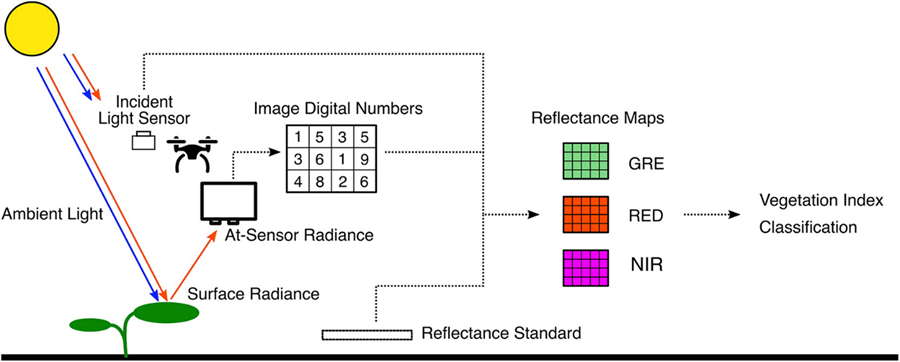
Figure 1:https://doi.org/10.1139/juvs-2018-0018

<p></p>

6. **Capturing the Images**
    * On the day you are flying, you should. Check the weather to ensure it is within drone limitations and won't adversely impact your data. If the light condition changes a lot across flights (i.e. clouds), rescheduling may be better. It is much easier to get good data than to try and correct for variance across the flight. 

### Background Reading

<a href="https://cdnsciencepub.com/doi/10.1139/juvs-2018-0018" target="_blank">Vegetation monitoring using multispectral sensors — best practices and lessons learned from high latitudes - Assmann et al. (2018)</a>

#### Recap quiz

**Why do you think calibration is required? What factors will affect that data? When does calibration matter?**

<details>
    <summary><b>answer</b></summary>
Weather changes, sun angle. Calibration is essential to compare changes in spectral indices across days or seasons, e.g. if we wish to monitor crop growth or health over time.
</details>

## Simple radiometric correction of Swan Valley imagery

You will use the skills you learnt across weeks 1-6 (working with GeoTIFF files, raster geoprocessing operations, band stacking, navigating directories and file systems with imagery stored different folders ect). 

Our post-processing will focus on the radiometric calibration of drone imagery to produce comparable vegetation indices across flights and days.

**The key objective for this week is to show the importance of calibration when working with drone imagery**. The satellite data we have worked with so far across weeks 1-6 has already had radiometric, spectral and geometric calibration applied by the data providers. For example, you can view the <a href="https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/document-library" target="_blank">Sentinel data quality report</a>.

This notebook is focused on simple radiometric calibration of 5-band multispectral imagery. The imagery you will be using was collected over the Swan Valley on by MicaSense RedEdge mounted on a DJI Phantom 4. For this lab, the imagery has been clipped to a small subsection containing some grapevines and the calibration panels to speed up processing.

Imagery bands:

* 1: Blue  
* 2: Greeb 
* 3: Red 
* 4: Red Edge 
* 5: Near Infrared


You will provided with:

1. A tif file for each camera band
2. A shape file that cover the calibration panels
3. A CSV file that contains the MicaSense RedEdge-MX band parmeters (you would normally need to look up wavelength centre and band width for each of the sensor bands in the camera specificaions).

### Download data

If you need to download the date for this lab, run the following code snippet. 

In [ ]:
import os

if "week-8" not in os.listdir(os.getcwd()):
    os.system('wget "https://github.com/data-analysis-3300-3003/data/raw/main/data/week-8.zip"')
    os.system('unzip "week-8.zip"')

### Import modules

In [ ]:
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
import plotly.io as pio
import plotly.express as px
import fiona
from rasterio.mask import mask
from sklearn.linear_model import LinearRegression

# setup renderer
if 'google.colab' in str(get_ipython()):
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "jupyterlab"

In [ ]:
!pip install rasterstats

In [ ]:
from rasterstats import zonal_stats

### Inspect data 

Before, getting started let's check the data files for this exercise have downloaded without error. You should be able to identify what data is stored in each file by the file's name. 

Let's also visualise the near infrared and red images captured by the MicaSense RedEdge-MX camera.

**Can you spot the calibration panels in the images?**

**Can you explain why the vines appear bright in the near infrared image and dark in the red image?**

In [ ]:
path_to_week8_data = os.path.join(os.getcwd(), "week-8")
os.listdir(path_to_week8_data)

In [ ]:
# visualise NIR data
swan_nir_path = os.path.join(path_to_week8_data, "swan_nir.tif")

with rasterio.open(swan_nir_path) as src:
    nir = src.read(1)
    
px.imshow(nir, height=500)

In [ ]:
# visualise RED data
swan_red_path = os.path.join(path_to_week8_data, "swan_red.tif")

with rasterio.open(swan_red_path) as src:
    red = src.read(1)
    
px.imshow(red, height=500)

### Task 1

Write some code to read in the calibration panel data stored in the shapefile `calibration_panels.shp`. Reference this data with a variable called `panel_gdf`.

In [ ]:
## ADD CODE HERE ##

<details>
    <summary><b>answer</b></summary>
    
```python

#Import shape file for panels
panel_path = os.path.join(os.getcwd(), "week-8", "calibration_panels.shp")
panel_gdf = gpd.read_file(panel_path)
```
</details>

Before moving on we need to reverse the ordering of the data in the `panel` column so it has a black-to-white ordering. Let's do this and also inspect the data. 

In [ ]:
#reverse b-w instead w-b 
panel_gdf = panel_gdf.iloc[::-1]
panel_gdf = panel_gdf.reset_index(drop=True)
panel_gdf.head()

### Task 2

Write some code to read in the asd data (measured spectra of the panels). This data is stored in the CSV file `panels_reflectance_values.csv` and you should read it into a pandas `DataFrame` referenced by the variable `asd`. An ASD spectroradiometer is used to accurately measure the spectral reflectance of each of the calibration panels. 

In [ ]:
## ADD CODE HERE ##

<details>
    <summary><b>answer</b></summary>
    
```python
#import asd data
asd_fp = os.path.join(os.getcwd(), "week-8", "panels_reflectance_values.csv")
asd = pd.read_csv(asd_fp)
asd.head()
```
</details>

In [ ]:
# summary of asd data
asd.describe()

### Task 3

Write some code to read in camera band values for the MicaSense RedEdge-MX band parmeters. This data is stored in the file `rededgemx_bands.csv`. Read this data into a pandas `DataFrame` referenced by the variable `mica_mx`.

In [ ]:
## ADD CODE HERE ##

<details>
    <summary><b>answer</b></summary>
 
```python
#read in camera band values
mica_mx_fp = os.path.join(os.getcwd(), "week-8", "rededgemx_bands.csv")
mica_mx = pd.read_csv(mica_mx_fp)
mica_mx.head()
```
</details>

### Task 4

Write some code to get known panel values for each of the MicaSense RedEdge-MX camera bands. There are a few steps to this task. So, take a few minutes to work through what is happenning in the below code snippet. We loop over each spectral waveband in the MicaSense RedEdge-MX camera band:

1. subset the upper and lower spectral reflectance values for each band
2. subset the asd measured spectral reflectance of calibration panels within the wavelength range corresponding to MicaSense RedEdge-MX camera bands
3. compute the mean of the asd measured spectral reflectance of calibration panels within the wavelength range corresponding to MicaSense RedEdge-MX camera bands

We assume that the asd measured spectral reflectance for each of the calibration panels is accurate and we implement these steps to compute what the asd measured spectral reflectance is for each of the MicaSense RedEdge-MX camera bands. Thus, we expect our drone imagery's spectral reflectance values over the calibration panels to match the asd data. If there are discrepancies, we adjust the drone imagery so it matches the asd measured spectral reflectance. This is radiometrically calibrating drone images.

Remember you can use `print()` statements to help visualise what your code is doing. 

In [ ]:
## ADD CODE HERE ##

<details>
    <summary><b>answer</b></summary>
 
```python
asd_panels = []

for i in mica_mx["band"]:
    print(f"processing MicaSense RedEdge-MX camera band: {i}")
    # For each band, subset the lower and upper band reflectance from the DataFrame mica_mx
    band_lowerlim = pd.Series(mica_mx[mica_mx["band"] == i]["band_low"]).item()
    band_upperlim = pd.Series(mica_mx[mica_mx["band"] == i]["band_up"]).item()
    
    # get asd values between the mica_mx band limits
    mx_asd = asd[(asd["Wavelength"] >= band_lowerlim) & (asd["Wavelength"] <= band_upperlim)]
    
    # compute the mean of asd values between mica_mx band limits
    mx_asd_panel_mean = mx_asd.mean() 
    asd_panels.append(mx_asd_panel_mean.iloc[1:].values)

surface_reflectance = pd.DataFrame(asd_panels, columns=panel_gdf["panel"])   
surface_reflectance.index= mica_mx["band"]

surface_reflectance.head()
```
</details>

### Task 5

Write some code to extract the mean digital number for the extent of each calibration panel in the drone imagery for each camera band. You will need to use the locations of the calibration panels that you read into your program in *Task 1* and are stored as polygons in the `GeoDataFrame` `panel_gdf`. You will need to use these polygons in a zonal statistics operation for each of the drone imagery's camera bands. Each band is stored in a separate GeoTIFF file. 

You can use the `zonal_stats()` function from the rasterstats package for this task (examples in the *lab-4-practice-exercises.ipynb* and *lab-6-practice-exercises.ipynb* notebooks). 

Try and use a for loop to iterate over the GeoTIFF files and apply the `zonal_stats()` function. This is a good example of how we can use a for loop to automate a repetitive task. Store the mean band digital numbers for the extent of each calibration panel in the drone imagery as a pandas `DataFrame`. 

In [ ]:
## ADD CODE HERE ##

<details>
    <summary><b>answer</b></summary>
 
```python
dn_panels = []

#extract digital number mean for each pannel 
for i in mica_mx["band"]:
    print(f"zonal stats for MicaSense RedEdge-MX camera band: {i}")
    
    # update path to GeoTIFF file for each camera band
    mg_fp= os.path.join(os.getcwd(), "week-8", f"swan_{i}.tif")
    
    # open the drone imagery for each camera band
    # read the drone imagery to a NumPy ndarray and get the georeferencing information (affine)
    with rasterio.open(mg_fp) as src:
        
        # NumPy ndarray of image digital number values
        band = src.read(1)
        affine = src.transform
        
        # use the zonal_stats function to compute mean digital number values for each of the calibration panels
        zs = zonal_stats(panel_gdf, band, stats="mean", affine=affine)
        
        zs = pd.DataFrame(zs)
        band_panel_dn = zs["mean"].values
        dn_panels.append(band_panel_dn)

mx_dn_panels = pd.DataFrame(dn_panels, columns=panel_gdf["panel"])
mx_dn_panels.index= mica_mx["band"]

mx_dn_panels.head()
```
</details>

### Task 6

Can you generate scatter plots that visualise the relationship between calibration panel's surface reflectance and their digital numbers in the drone images? The drone image digital numbers for the panels are stored in the `DataFrame` `mx_dn_panels` and the calibration panel's surface reflectance is stored in the `DataFrame` `surface_reflectance`. Remember you can use the `head()` function to glimpse at the structure of the data in these `DataFrame`s. Also, remember you can look up reference information for creating scatter plots in the Plotly Express docs. 

In [ ]:
## ADD CODE HERE ##

<details>
    <summary><b>answer</b></summary>
 
```python
for i in mica_mx["band"]:
    fig= px.scatter(
        x=mx_dn_panels.loc[i], 
        y=surface_reflectance.loc[i], 
        trendline="ols",
        title=i)
    
    fig.update_layout(
        xaxis_title="Digital Number",
        yaxis_title="Surface Reflectance"
    )
    
    fig.show()
```
</details>

### Task 7 

In the *lab-5.ipynb and lab-5-self-guided.ipynb* notebooks you used Scikit-learn to train machine learning models. We need to create a linear regression model that will learn relationships between a calibration panel's surface reflectance (measured by the asd) and the calibration panel's digital number captured by the drone for each camera band. We can then use this model to correct the drone images to surface reflectance. Have a go at fitting this linear regression model using Scikit learn and correcting the drone images. If you get stuck, check the answer and make sure you take time to understand what each step in the code is doing.

In [ ]:
## ADD CODE HERE ##

<details>
    <summary><b>answer</b></summary>
 
```python
# create a list to save corrected outputs
corrected_images = []

for i in mica_mx["band"]: 
    print(f"")
    print(f"correcting band {i}")
    
    x = mx_dn_panels.loc[i].values.reshape(-1,1)
    y = surface_reflect.loc[i].values.reshape(-1,1)
    
    model = LinearRegression().fit(x, y)
    #Obtain the coefficient of determination by calling the model with the score() function, then print the coefficient:
    r_sq = model.score(x, y)
    intercept = model.intercept_[0]
    coef = model.coef_[0][0]
    print("coefficient of determination:", r_sq)
    #Print the Intercept:
    print("intercept:", intercept)
    #Print the Slope:
    print("slope:", coef)

    #read in raw dn image and apply correction and save
    mg_fp= os.path.join(os.getcwd(), "week-8", f"swan_{i}.tif")
    with rasterio.open(mg_fp) as src:
        band = src.read(1)
    
    # use the model to radiometrically correct drone image
    band_corrected = coef*band + intercept
    
    # visualise outputs
    fig_dn = px.imshow(band, title = f"DN band {i}")
    fig_dn.show()
    
    fig_corr = px.imshow(band_corrected, title = f"corrected band {i}")
    fig_corr.show()
    
    # store corrected images as a list
    corrected_images.append(band_corrected)
```
</details>

Let's check an RGB image of the vineyard looks sensible. 

In [ ]:
# create an rgb image of the corrected data
red_band = corrected_images[2]
green_band = corrected_images[1]
blue_band = corrected_images[0]

# make RGB image
rgb = np.stack((red_band, green_band, blue_band), axis=0)

# plot the rgb image
px.imshow(np.moveaxis(rgb, 0, 2), contrast_rescaling="minmax", height=500)

### Task 7

Create a vegetation index (e.g NDVI) from your corrected data. NumPy `ndarray` objects storing the corrected data are elements in the list `corrected_images` at the following index locations:

0. blue
1. green
2. red
3. red edge
4. near infrared

You can see examples of computing the NDVI from NumPy `ndarray`s in *lab-4.ipynb*. 

<details>
    <summary><b>answer</b></summary>
 
This one's on you... you've got it!

</details>